In [48]:
from pathlib import Path
import random
import json
import textwrap

import pandas as pd

pd.set_option("display.max_colwidth", 200)

In [49]:
REPO_ROOT = Path("..").resolve()

INTERIM_DIR = REPO_ROOT / "data" / "interim"
PROCESSED_DIR = REPO_ROOT / "data" / "processed"

CLEAN_PAGES_PATH = INTERIM_DIR / "fandom_pages_clean.jsonl"
SECTIONS_PATH = INTERIM_DIR / "sections_parsed_money-heist.jsonl"
SPANS_PATH = PROCESSED_DIR / "spans_money-heist.csv"

print("Repo root:", REPO_ROOT)
print("Clean pages exists:", CLEAN_PAGES_PATH.exists())
print("Sections parsed exists:", SECTIONS_PATH.exists())
print("Spans.csv exists:", SPANS_PATH.exists())

Repo root: /data/sundeep/Fandom_SI
Clean pages exists: False
Sections parsed exists: True
Spans.csv exists: True


In [50]:
def read_jsonl(path, max_lines=5):
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= max_lines:
                break
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows

if SECTIONS_PATH.exists():
    sample_sections = read_jsonl(SECTIONS_PATH, max_lines=5)
    print("Number of sample records:", len(sample_sections))
    if sample_sections:
        print("Keys in first record:", sample_sections[0].keys())
        pd.DataFrame(sample_sections)
else:
    print("sections_parsed.jsonl not found – skip this part or check your paths.")

Number of sample records: 5
Keys in first record: dict_keys(['article_id', 'page_name', 'title', 'section', 'text', 'url', 'source_path', 'links'])


In [51]:
if SECTIONS_PATH.exists():
    # Load more lines to have more pages to choose from
    all_sections = []
    with SECTIONS_PATH.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            all_sections.append(json.loads(line))
            if i > 5000:  # cap to avoid loading a giant file
                break

    print(f"Loaded {len(all_sections)} section records.")

    df_sections = pd.DataFrame(all_sections)
    print("Columns in df_sections:", list(df_sections.columns))

    # Adjust these if your column names differ
    assert "article_id" in df_sections.columns, "Adjust: no 'page_id' column found."
    assert "text" in df_sections.columns, "Adjust: no 'text' column found."

    # Choose a random page_id
    page_ids = df_sections["article_id"].unique().tolist()
    random_page_id = random.choice(page_ids)
    random_page_id
else:
    print("No sections_parsed.jsonl – cannot build page text from sections.")
    df_sections = None
    random_page_id = None

Loaded 1828 section records.
Columns in df_sections: ['article_id', 'page_name', 'title', 'section', 'text', 'url', 'source_path', 'links']


In [52]:
if df_sections is not None and random_page_id is not None:
    df_page_sections = df_sections[df_sections["article_id"] == random_page_id].copy()

    print("Random page_id:", random_page_id)
    display(df_page_sections[["article_id", "text"]].head())

    # Concatenate section texts with newlines
    page_text = "\n\n".join(df_page_sections["text"].tolist())
    print("Total chars in reconstructed page_text:", len(page_text))

    print("\n=== First 1000 chars of page_text ===")
    print(textwrap.shorten(page_text.replace("\n", " "), width=1000, placeholder=" ..."))
else:
    print("Skipping – no df_sections or random_page_id.")

Random page_id: 890


,article_id,text
217,890,Ariadna Cascales Biographical Information Nickname(s) Ari (by Mónica Gaztambide ) Gender Female Status Alive Relationships Romance(s) Berlin (former fling) Friends Nairobi (formerly) Mónica Gaztam...
218,890,"Ariadna is an employee of the mint who is taken hostage. Not much is known about her background, however she takes Sertraline, an anti-anxiety medication.\nDuring the heist, Ariadna witnesses host..."
219,890,"During the final shootout, she is forced by Berlin to take part. However, she survives as she is seen alive after Berlin dies."
220,890,Ariadna has brown hair.
221,890,"During the heist at the Royal Mint of Spain , Berlin meets Ariadna Cascales, an employee of the mint who is taken hostage. Early in the heist, when Ariadna trembles in fear, Berlin approaches her ..."


Total chars in reconstructed page_text: 2172

=== First 1000 chars of page_text ===
Ariadna Cascales Biographical Information Nickname(s) Ari (by Mónica Gaztambide ) Gender Female Status Alive Relationships Romance(s) Berlin (former fling) Friends Nairobi (formerly) Mónica Gaztambide Enemies Berlin Professional Information Occupation Employee at the Royal Mint of Spain Series Information Part(s) 1 , 2 Portrayed by Clara Alvarado First appearance Latest appearance Episode 1 (Part 1) Episode 9 (Part 2) Ariadna Cascales is an employee of the Royal Mint of Spain who is taken hostage. Ariadna is an employee of the mint who is taken hostage. Not much is known about her background, however she takes Sertraline, an anti-anxiety medication. During the heist, Ariadna witnesses hostages being intimidated and taken away. Out of fear, she "seduces" the leader of the heist, Berlin , thinking that it will increase her odds of surviving. During the final shootout, she is forced by Berlin to take part.

In [53]:
if SPANS_PATH.exists():
    df_spans = pd.read_csv(SPANS_PATH)
    print("Columns in spans.csv:", list(df_spans.columns))
    print("Number of spans total:", len(df_spans))
else:
    print("spans.csv not found – run your span-building script first.")
    df_spans = None

Columns in spans.csv: ['span_id', 'article_id', 'page_name', 'title', 'section', 'span_index', 'start_char', 'end_char', 'len_chars', 'num_sents', 'text', 'url', 'source_path']
Number of spans total: 3189


In [54]:
if df_spans is not None and random_page_id is not None:
    # Adjust column names here if needed
    assert "article_id" in df_spans.columns, "No 'page_id' in spans.csv"
    assert "span_id" in df_spans.columns, "No 'span_id' in spans.csv"
    # I assume "char_start" and "char_end"
    assert "start_char" in df_spans.columns, "No 'char_start' in spans.csv"
    assert "end_char" in df_spans.columns, "No 'char_end' in spans.csv"

    df_page_spans = df_spans[df_spans["article_id"] == random_page_id].copy()
    print(f"Spans for page {random_page_id}: {len(df_page_spans)}")

    if len(df_page_spans) == 0:
        print("⚠️ No spans found for this page_id. Try rerunning or check your span-building code.")
    else:
        sample_spans = df_page_spans.sample(n=min(5, len(df_page_spans)), random_state=42)
        display(sample_spans.head())

        def show_span_with_context(row, context_window=60):
            s = int(row["start_char"])
            e = int(row["end_char"])

            print("\n====================================")
            print(f"span_id: {row['span_id']}")
            print(f"Offsets: [{s}, {e})")

            # Bounds check
            if s < 0 or e > len(page_text) or s >= e:
                print("⚠️ Invalid offsets with respect to page_text length.")
                return

            span_text_from_offsets = page_text[s:e]

            # Optionally compare to stored span text if exists
            if "text" in row:
                stored = str(row["text"])
            else:
                stored = None

            # Build context snippet
            left = max(0, s - context_window)
            right = min(len(page_text), e + context_window)
            context = page_text[left:right]

            # Mark span within context
            relative_start = s - left
            relative_end = relative_start + (e - s)
            marked = (
                context[:relative_start]
                + "[["
                + context[relative_start:relative_end]
                + "]]"
                + context[relative_end:]
            )

            print("\n--- Context with marked span ---")
            print(textwrap.fill(marked.replace("\n", " "), width=120))

            print("\n--- Span extracted from offsets ---")
            print(repr(span_text_from_offsets))

            if stored is not None:
                print("\n--- Span text stored in CSV ---")
                print(repr(stored))

        for _, row in sample_spans.iterrows():
            show_span_with_context(row)

else:
    print("Either df_spans is None or random_page_id is None – cannot inspect spans.")

Spans for page 890: 6


,span_id,article_id,page_name,title,section,span_index,start_char,end_char,len_chars,num_sents,text,url,source_path
362,money-heist_span_0000363,890,Ariadna_Cascales,Ariadna Cascales,Introduction,0,0,502,502,1.0,Ariadna Cascales Biographical Information Nickname(s) Ari (by Mónica Gaztambide ) Gender Female Status Alive Relationships Romance(s) Berlin (former fling) Friends Nairobi (formerly) Mónica Gaztam...,https://money-heist.fandom.com/wiki/Ariadna_Cascales,data/raw/fandom_html/money-heist/money-heist_fandom_com_wiki_Ariadna_Cascales.html
363,money-heist_span_0000364,890,Ariadna_Cascales,Ariadna Cascales,Part 1 [ ],0,0,348,348,4.0,"Ariadna is an employee of the mint who is taken hostage. Not much is known about her background, however she takes Sertraline, an anti-anxiety medication.\r\nDuring the heist, Ariadna witnesses ho...",https://money-heist.fandom.com/wiki/Ariadna_Cascales,data/raw/fandom_html/money-heist/money-heist_fandom_com_wiki_Ariadna_Cascales.html
367,money-heist_span_0000368,890,Ariadna_Cascales,Ariadna Cascales,Berlin [ ],2,860,1143,283,3.0,"[ 1 ] Nairobi later reveals this information to Berlin.\r\nDuring the final shootout with police, Berlin forces Ariadna to stay with him while he guards the tunnel that the other crew members are ...",https://money-heist.fandom.com/wiki/Ariadna_Cascales,data/raw/fandom_html/money-heist/money-heist_fandom_com_wiki_Ariadna_Cascales.html
364,money-heist_span_0000365,890,Ariadna_Cascales,Ariadna Cascales,Part 2 [ ],0,0,126,126,2.0,"During the final shootout, she is forced by Berlin to take part. However, she survives as she is seen alive after Berlin dies.",https://money-heist.fandom.com/wiki/Ariadna_Cascales,data/raw/fandom_html/money-heist/money-heist_fandom_com_wiki_Ariadna_Cascales.html
366,money-heist_span_0000367,890,Ariadna_Cascales,Ariadna Cascales,Berlin [ ],1,450,859,409,4.0,"In an office, she ""seduces"" him, thinking that it will increase her odds of surviving the heist. They regularly have sex, which Ariadna describes to Mónica as rape because of her hate for him desp...",https://money-heist.fandom.com/wiki/Ariadna_Cascales,data/raw/fandom_html/money-heist/money-heist_fandom_com_wiki_Ariadna_Cascales.html



span_id: money-heist_span_0000363
Offsets: [0, 502)

--- Context with marked span ---
[[Ariadna Cascales Biographical Information Nickname(s) Ari (by Mónica Gaztambide ) Gender Female Status Alive
Relationships Romance(s) Berlin (former fling) Friends Nairobi (formerly) Mónica Gaztambide Enemies Berlin Professional
Information Occupation Employee at the Royal Mint of Spain Series Information Part(s) 1 , 2 Portrayed by Clara Alvarado
First appearance Latest appearance Episode 1 (Part 1) Episode 9 (Part 2) Ariadna Cascales is an employee of the Royal
Mint of Spain who is taken hostage.]]  Ariadna is an employee of the mint who is taken hostage. N

--- Span extracted from offsets ---
'Ariadna Cascales Biographical Information Nickname(s) Ari (by Mónica Gaztambide ) Gender Female Status Alive Relationships Romance(s) Berlin (former fling) Friends Nairobi (formerly) Mónica Gaztambide Enemies Berlin Professional Information Occupation Employee at the Royal Mint of Spain Series Information P

Span length stats:
count    3189.000000
mean      256.026341
std       171.477605
min        30.000000
25%       111.000000
50%       240.000000
75%       376.000000
max      1024.000000
Name: span_length, dtype: float64


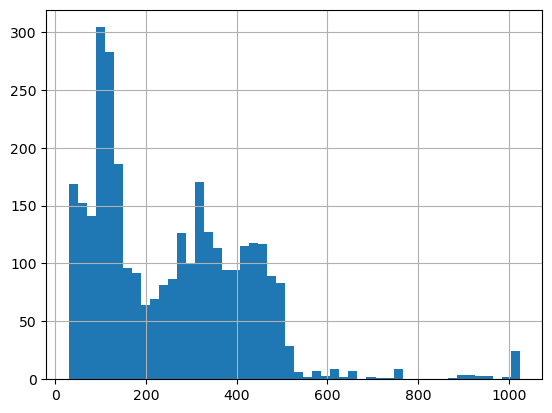

In [55]:
if df_spans is not None:
    df_spans["span_length"] = df_spans["end_char"] - df_spans["start_char"]
    print("Span length stats:")
    print(df_spans["span_length"].describe())

    df_spans["span_length"].hist(bins=50)